# Interactive Julia for *A Simple Nearly-optimal Restart Scheme for Speeding-Up First Order Methods* #

### James Renegar, Benjamin Grimmer ###
___

This notebook follows along the ideas presented in [[1]](https://arxiv.org/abs/1803.00151). Its purpose is to give a simple and understandable implementation of the algorithms and concepts therein. Throughout this document, we may reference equations, lemmas, and theorems using the numbering given in that paper. 

The general outline of this document is the following:

1. Implementation of Basic Synchronous Scheme
2. Solving Some Simple Problems:
    * --- via Subgradient Method
    * --- via Accelerated Method
3. Implementation of Parallel Asynchronous Scheme
4. Solving an Interesting Problems:
    * --- via Inexact Proximal Point Method

**License**: Creative Commons License

This work is licensed under a Creative Commons Attribution-ShareAlike 4.0 International License (http://creativecommons.org/licenses/by-sa/4.0/).

An MIT License for the underlying software is provided in the separate LICENSE file.

**Disclaimer**: We make no claim that the code below is optimized or the most efficient version possible. Instead our goal is to give the simplest implementation possible. Speedups are certainly possible using optimized linear algebra packages and by taking advantage of sparsity and problem specific structure.

Any questions or feedback on this document can be sent to Ben Grimmer at *bdg79@cornell.edu*. 

[1] "A Simple Nearly-Optimal Restart Scheme For Speeding-Up First Order Methods", https://arxiv.org/abs/1803.00151. James Renegar, Benjamin Grimmer. First posted March 1st, 2018.

In [1]:
#Importing plotting package to be used
using PyPlot

#Launching 16 threads for parallel algorithm to eventually use.
#Our code below will all have the macro @everything attached to share the definitions with these threads
processes = addprocs(16) 

16-element Array{Int64,1}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16
 17

# Implementation of Basic Synchronous Scheme #

In [2]:
@everywhere abstract type problem_instance end
@everywhere abstract type algorithm_state end 
@everywhere type algorithm
        initialization
        iteration
    end;

In [3]:
function direct_scheme(alg::algorithm, inst::problem_instance, x0, epsilon::Float64, T::Int64)
    #Apply alg to the inst starting from x0 for T iterations
    
    ret = Array{Float64}(T+1) #Record of minimum objective value seen at each iteration
    ret[1] = inst.f(x0)
    
    state = alg.initialization(inst, x0, epsilon)
    
    for i in 1:T 
        alg.iteration(state)
        ret[i+1] = min(ret[i], inst.f(state.iterate))
    end
    return ret, state.iterate
end;

In [4]:
function synchronuous_restarting_scheme(alg::algorithm, inst::problem_instance, x0, epsilon::Float64, T::Int64)
    ret = Array{Float64}(T+1) #Record of minimum objective value seen at each iteration
    ret[1] = inst.f(x0)
    
    N = max(2,ceil(Int64, -1*log(2,epsilon))) #Compute how many processes to use
    eps = Array{Float64}(N)            #Accuracy level used by each algorithm instance
    states = Array{algorithm_state}(N) #Current state of each parallel algorithm instance
    objs = Array{Float64}(N)           #Target objective value of each algorithm instance
    
    for j in 1:N #Initialization loop
        eps[j] = 2.0^(-1*j)
        states[j] = alg.initialization(inst, x0, eps[j])
        objs[j] = inst.f(x0) - eps[j]
    end

    for i in 1:T
        #Handle first process since its special
        value = inst.f(states[1].iterate)
        if value < objs[2]
            states[2] = alg.initialization(inst, states[1].iterate, eps[2])
            objs[2] = value - eps[2]
        end
        alg.iteration(states[1])
        
        #Handle the middle processes
        for j in 2:(N-1)
            value = inst.f(states[j].iterate)
            if value < objs[j+1]
                states[j+1] = alg.initialization(inst, states[j].iterate, eps[j+1])
                objs[j+1] = value - eps[j+1]
            end
            if value < objs[j]
                states[j] = alg.initialization(inst, states[j].iterate, eps[j])
                objs[j] = value - eps[j]
            end
            alg.iteration(states[j])
        end

        #Handle last process since its special
        value = inst.f(states[N].iterate)
        if value < objs[N]
            states[N] = alg.initialization(inst, states[N].iterate, eps[N])
            objs[N] = value - eps[N]
        end
        alg.iteration(states[N])
        ret[i+1] = min(ret[i], inst.f(states[N].iterate))
    end
    return ret, states[N].iterate
end;

# Solving Some Simple Problems #

### The Subgradient Method ###
 We begin by defining arguably the simplest first-order method, the *subgradient method*.

In [5]:
@everywhere type subgradientMethod_instance <: problem_instance
        f
        subgrad_f
    end
@everywhere type subgradientMethod_state <: algorithm_state
        instance::subgradientMethod_instance
        iterate
        epsilon::Float64
    end

@everywhere function subgradientMethod_initialization(inst::subgradientMethod_instance, x0, epsilon::Float64)
        return subgradientMethod_state(inst, x0, epsilon)
    end
@everywhere function subgradientMethod_iteration(state::subgradientMethod_state)
        g = state.instance.subgrad_f(state.iterate)
        if norm(g) > 0.0001
            state.iterate = state.iterate - state.epsilon*g/norm(g)^2
        end
    end

@everywhere subgradientMethod = algorithm(subgradientMethod_initialization, subgradientMethod_iteration);

Then for any problem where we can give a subgradient oracle, we can immidiately apply the subgradient method directly (via direct_scheme()) or in a parallel fashion (via synchronuous_restarting_scheme()).

Consider minimizing the one norm of a vector
$$ f(x) = \|x\|_1.$$
We define an instance of this simple problem as follows:

In [6]:
@everywhere function oneNorm(x)
    norm(x,1)
end
@everywhere function subgrad_oneNorm(x)
    g = zeros(length(x))
    for i in 1:length(x)
        if x[i]>0.0001
            g[i]=1
        elseif x[i]<-0.0001
            g[i]=-1
        else
            g[i]=0
        end
    end
    return g
end

@everywhere oneNorm_instance = subgradientMethod_instance(oneNorm, subgrad_oneNorm);

Below apply many iterations of the subgradient method directly and apply many iterations via our restarting scheme. Plotting the result of this simple example shows a very quick linear convergence for our restarting method (as one would expect from Theorem ?? of [[1]](https://arxiv.org/abs/1803.00151)) since the one norm is both Lipschitz and sharp.

In [7]:
history1, final_state1 = direct_scheme(subgradientMethod, oneNorm_instance, [1.07,0.0,-2.1], 0.05, 100);

In [8]:
history2, final_state2 = synchronuous_restarting_scheme(subgradientMethod, oneNorm_instance, [1.07,0.0,-2.1], 0.05, 100);

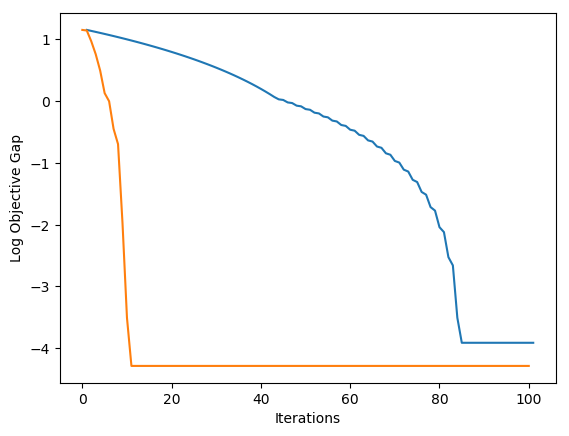

In [9]:
plot(1:101, log.(history1), log.(history2))
xlabel("Iterations")
ylabel("Log Objective Gap");

### Nesterov's Accelerated Gradient Method ###

In [10]:

@everywhere type acceleratedMethod_instance <: problem_instance
        f
        grad_f
        L::Float64
    end
@everywhere type acceleratedMethod_state <: algorithm_state
        instance::acceleratedMethod_instance
        prev_iterate
        iterate
        counter::Int64
    end

@everywhere function acceleratedMethod_initialization(inst::acceleratedMethod_instance, x0, epsilon::Float64)
        return acceleratedMethod_state(inst, x0, x0, 0)
    end
@everywhere function acceleratedMethod_iteration(state::acceleratedMethod_state)
        k = state.counter
        x1 = state.iterate
        x0 = state.prev_iterate
        y = x1 + (k+2)/(k+1)*(x1 - x0)
        g = state.instance.grad_f(y)
    
        state.prev_iterate = x1
        state.iterate = y - g/state.instance.L
        state.counter = k+1
    end

@everywhere acceleratedMethod = algorithm(acceleratedMethod_initialization, acceleratedMethod_iteration);

Then for any problem where we can give a gradient oracle and bound the Lipschitz constant of the gradient, we can immidiately apply the accelerated method directly (via direct_scheme()) or in a parallel fashion (via synchronuous_restarting_scheme()).

Consider solving a least squares problem plus a smooth regularizer.
$$ f(x) = \|Ax-b\|_2^2 + \|x\|^4_4.$$
We define an instance of this simple problem as follows (setting $b=0$ so that we know the optimal objective value is zero):

In [11]:
A = randn(10,5)
b = zeros(10) #randn(10)
function leastSquares(x)
    norm(A*x-b)^2 + norm(x,4)^4
end
function grad_leastSquares(x)
    return A'*(A*x-b) + 4*x.^3
end
#The lipschitz constant from the regularizer will depend on how close to optimal the method starts. We'll fudge it and say 200.
leastSquares_instance = acceleratedMethod_instance(leastSquares, grad_leastSquares, norm(A)^2+200);

Below apply many iterations of the subgradient method directly and apply many iterations via our restarting scheme. Plotting the result of this test shows the restarting scheme also provides an improvement to the convergence here.

In [12]:
history1, final_state1 = direct_scheme(acceleratedMethod, leastSquares_instance, [1.07,5.0,-2.1,3.0,-0.1], 0.005, 100);

In [13]:
history2, final_state2 = synchronuous_restarting_scheme(acceleratedMethod, leastSquares_instance, [1.07,5.0,-2.1,3.0,-0.1], 0.005, 100);

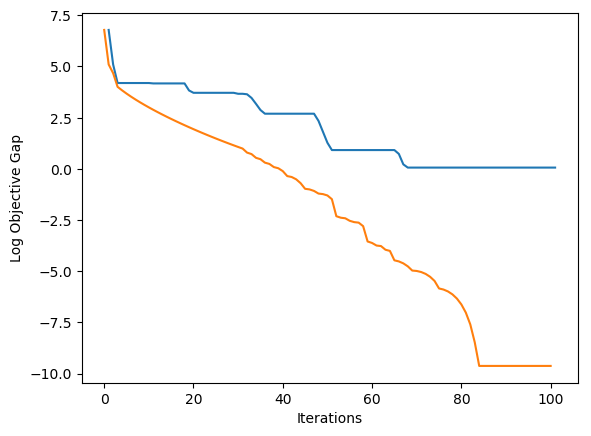

In [14]:
plot(1:101, log.(history1), log.(history2))
xlabel("Iterations")
ylabel("Log Objective Gap");

# Implementation of Parallel Asynchronous Scheme #

In [15]:
function asynchronuous_restarting_scheme(alg::algorithm, inst::problem_instance, x0, epsilon::Float64, T::Int64)    
    N = min(16, max(2,ceil(Int64, -1*log(2,epsilon))))   #Compute how many processes to use, must be between 2 and 8
    
    @everywhere function first_worker_loop(alg::algorithm, inst::problem_instance, x0, epsilon::Float64, T::Int64,
                    output::RemoteChannel{Channel{Tuple}})
        ret = Array{Float64}(T+1) #Record of minimum objective value seen at each iteration
        ret[1] = inst.f(x0)
        state = alg.initialization(inst, x0, epsilon)
        obj = inst.f(x0) - epsilon
        for i in 1:T
            alg.iteration(state)
            value = inst.f(state.iterate)
            ret[i+1] = min(ret[i], value)
            if value < obj
                obj = value - epsilon
                put!(output, (state.iterate, value))
            end
        end
        ret, state.iterate
    end
    @everywhere function middle_worker_loop(alg::algorithm, inst::problem_instance, x0, epsilon::Float64, T::Int64, 
                    input::RemoteChannel{Channel{Tuple}}, output::RemoteChannel{Channel{Tuple}})
        ret = Array{Float64}(T+1) #Record of minimum objective value seen at each iteration
        ret[1] = inst.f(x0)
        
        state = alg.initialization(inst, x0, epsilon)
        obj = inst.f(x0) - epsilon
        for i in 1:T
            alg.iteration(state)
            x, value = state.iterate, inst.f(state.iterate)
            ret[i+1] = min(ret[i], value)
            while isready(input)
                y, v = take!(input)
                if v<value
                    x, value = y,v
                end
            end
            if value < obj
                obj = value - epsilon
                state = alg.initialization(inst, x, epsilon)
                put!(output, (x, value))
            end
        end 
        ret, state.iterate
    end
    @everywhere function last_worker_loop(alg::algorithm, inst::problem_instance, x0, epsilon::Float64, T::Int64, 
                    input::RemoteChannel{Channel{Tuple}})
        ret = Array{Float64}(T+1) #Record of minimum objective value seen at each iteration
        ret[1] = inst.f(x0)
    
        state = alg.initialization(inst, x0, epsilon)
        obj = inst.f(x0) - epsilon
        for i in 1:T
            alg.iteration(state)
        
            x, value = state.iterate, inst.f(state.iterate)
            ret[i+1] = min(ret[i], value)
            while isready(input)
                y, v = take!(input)
                if v<value
                    x, value = y,v
                end
            end
            if value < obj
                obj = value - epsilon
                state = alg.initialization(inst, x, epsilon)
            end
        end
        return ret, state.iterate
    end
    
    inputs = Array{RemoteChannel{Channel{Tuple}}}(N-1)
    for j in 1:(N-1)
        inputs[j] = RemoteChannel(()->Channel{Tuple}(32));
    end
    #Assigning each thread its task
    begin
        for j in 1:N
            p = processes[j]
            if j==1
                #Launch first process
                @sync println("Process: ",j," : ", remotecall_fetch(first_worker_loop, p, alg, inst, x0, 2.0^(-1*1), T, inputs[1]))
            elseif j<N
                #Launch middle processes
                @sync println("Process: ",j," : ", remotecall_fetch(middle_worker_loop, p, alg, inst, x0, 2.0^(-1*j), T, inputs[j-1], inputs[j]))
            else
                #Launch last process
                println("Process: ",j," : ", remotecall_fetch(last_worker_loop, p, alg, inst, x0, 2.0^(-1*N), T, inputs[N-1]))
            end
        end
    end 
end;

In [16]:
asynchronuous_restarting_scheme(subgradientMethod, oneNorm_instance, [1.07,0.0,-2.1], 0.001, 100);

Process: 1 : ([3.17, 2.67, 2.17, 1.67, 1.17, 1.03, 0.67, 0.53, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17], [0.07, 0.0, -0.1])
Process: 2 : ([3.17, 2.92, 0.53, 0.42, 0.28, 0.17, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.

# Solving an Interesting Problem #